In [34]:
import numpy as np


In [76]:
class BBG:
	def __init__(self, alpha: float=2.0, epsilon: float=1.0):
		self.alpha = alpha
		self.epsilon = epsilon
	
	#mxn matrix -> m points, each are in R^n. 
	def run(self, points: np.ndarray, k: int=-1):
		m = points.shape[0]
		n = points.shape[1]
		distances = BBG.get_euclidean_distances(points)
		sorted_distances = np.sort(np.unique(np.ravel(distances)))
		for tau in sorted_distances:
			tau_neighbors = np.where(distances <= tau, 1, 0) 
			# zero out the diagonal
			np.fill_diagonal(tau_neighbors, 0)
			b = (1 + 5/self.alpha)*self.epsilon*n
			H = np.zeros((m, m))

			#if somebody wants to find a more numpy/pythonic way to this 
			#feel free to change it
			for (r, c) in list(zip(range(m), range(m))):
				H[r][c] = np.count_nonzero(np.logical_and(tau_neighbors[r], tau_neighbors[c]))
			H = np.where(H >= b, 1, 0) # H contains the number of shared neighbors between each pair of points
			connected_components = BBG.find_components(H)
			top_k_component_indices = BBG.get_topk_components(connected_components, k)
			top_k_components = [connected_components[i] for i in top_k_component_indices]
			# print("tau: ", tau, " num components: ", len(top_k_components), "components: ", top_k_components)
			total_points_in_all_components = sum(map(lambda x: len(x), top_k_components))
			min_num_points_in_component = min(map(lambda x: len(x), top_k_components))
			# can we run the last step?
			if min_num_points_in_component > b and total_points_in_all_components >= m*(1 - self.epsilon - 5*self.epsilon/self.alpha):
				break
			 
		clusters = BBG.label_points(distances, top_k_components)
		return clusters
		

	@staticmethod
	def label_points(distances, clusters):
		# distances is an mxm matrix where the (i,j) index contains the distance from point i to point j
		# clusters is a list of lists of indices where each list of indices represents a cluster
		# returns a list of labels of size m where the ith index contains the label of point i according to the 
		# minimum median distance from point i to all other points in each cluster
		labels = np.zeros(len(distances))
		for i in range(len(distances)):
			min_median = float('inf')
			for cluster_index, cluster in enumerate(clusters):
				median = np.median(distances[i][cluster])
				if median < min_median:
					min_median = median
					labels[i] = cluster_index
		return labels


		

	@staticmethod
	def find_components(H: np.ndarray): 
		visited = [False]*len(H)
		components = []
		for i in range(len(H)):
			if visited[i]:
				continue
			stack = [i]
			component = []
			while len(stack) != 0:
				curr = stack.pop()
				if visited[curr]:
					continue
				visited[curr] = True
				component.append(curr)
				stack.extend(list(np.ravel(np.argwhere(H[curr]))))
			components.append(component)
		return components

	@staticmethod
	def get_euclidean_distances(points: np.ndarray): 
		#points consists of m n-dim points in an mxn array. 
		#output is an mxm array where the (i,j) index contains
		#the distance from point i to point j in points. 
		return np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)

	@staticmethod
	def get_topk_components(components, k):
		#components is a np list of lists of indices.
		#k is the number of components to return
		#returns the top k components by size
		# map the length of each component to its index
		sizes = np.array(list(map(lambda x: len(x), components)))
		return np.argpartition(sizes, -k)[-k:]
		

In [77]:
"""
0  -  3 - 2

1

4

"""



# graph = np.zeros((10, 10))
# graph[0][3] = graph[3][0] = graph[1][3] = graph[3][1] = 1

# graph[4][5] = graph[5][4] = 1

# graph[7][8] = graph[8][7] = graph[8][9] = graph[9][8] = 1

# components = BBG.find_components(graph)
# print(components)
# print(BBG.get_topk_components(components, 3))
# [[4,5] [0,3,1] [7,8,9]]
# [

# 

# create dummy data to test algorithm
# sample 100 points from a 2d gaussian distribution
points = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 100)
bbg = BBG()
clusters = bbg.run(points, 3)


# graph clustering



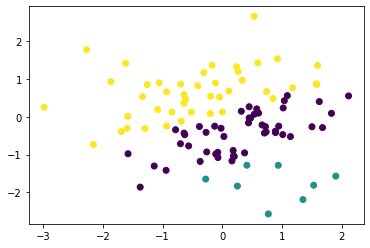

In [75]:
# graph points and color them according to their cluster
import matplotlib.pyplot as plt
plt.scatter(points[:, 0], points[:, 1], c=clusters)
plt.show()